In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
import os            ##  This module is for "operating system" interfaces
import sys           ##  This module is for functionality relevant to the python run time
path_to_datafolder = 'C:/Users/mjdom/source/repos/mdst_nlp_2021/data'
print(os.listdir(path_to_datafolder))


['test.csv', 'train.csv']


In [3]:
df = pd.read_csv(path_to_datafolder+'/train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
X = df["text"].copy()
#X = df["text"]

authors = df["author"].copy()

# Label data
y = []
for author in authors:
    if author == "EAP":
        y.append([1, 0, 0])
    if author == "HPL":
        y.append([0, 1, 0])
    if author == "MWS":
        y.append([0, 0, 1])

y = np.array(y)

y_one_vector = []
for author in authors:
    if author == "EAP":
        y_one_vector.append(0)
    if author == "HPL":
        y_one_vector.append(1)
    if author == "MWS":
        y_one_vector.append(2)

y_one_vector = np.array(y_one_vector)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## "Encoder" part of a Transformer model

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)



    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [7]:
sequence_length = 100
max_features = 1000000
# Token locations
Vectorizer_transformer = tf.keras.layers.TextVectorization(max_tokens=max_features,output_sequence_length=sequence_length) 
Vectorizer_transformer.adapt(X)
vocab = Vectorizer_transformer.get_vocabulary()
vocab_size = len(vocab)


embed_dim =32  # Embedding size for each token
num_heads =2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = sequence_length
dropout_rate = 0.3 # Dropout rate of feed forward network 

## Build embedding and transformer
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim,dropout_rate)

## Connect Keras Layers
inputs = tf.keras.Input(shape=(1,), dtype=tf.string) 
vec = Vectorizer_transformer(inputs)
x = embedding_layer(vec)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(3, activation="softmax")(x)

transformer = keras.Model(inputs=inputs, outputs=outputs) ##Final Model

In [8]:
transformer.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

history = transformer.fit(X_train, y_train, batch_size=128, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
123/123 [==============================] - 3s 15ms/step - loss: 0.9458 - accuracy: 0.5625 - val_loss: 0.6493 - val_accuracy: 0.7561
Epoch 2/2
123/123 [==============================] - 2s 14ms/step - loss: 0.4434 - accuracy: 0.8240 - val_loss: 0.4091 - val_accuracy: 0.8378


In [9]:
transformer.evaluate(X_test, y_test)

123/123 [==============================] - 1s 4ms/step - loss: 0.4091 - accuracy: 0.8378


[0.40913712978363037, 0.837844729423523]

### Usually provides around 0.42 - 0.44 log loss
## Let's perform a short random search on embed_dim, num_heads ,ff_dim, drop out rate and number of epochs


In [10]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
sequence_length = 100
max_features = 1000000
# Token locations
Vectorizer_transformer = tf.keras.layers.TextVectorization(max_tokens=max_features,output_sequence_length=sequence_length) 
Vectorizer_transformer.adapt(X)
vocab = Vectorizer_transformer.get_vocabulary()
vocab_size = len(vocab)


def create_model(embed_dim=32,num_heads = 2,ff_dim = 32,dropout_rate = 0.2):
    
    # create model


    maxlen = sequence_length

    ## Build embedding and transformer
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim,dropout_rate)

    ## Connect Keras Layers
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string) 
    vec = Vectorizer_transformer(inputs)
    x = embedding_layer(vec)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(3, activation="softmax")(x)

    transformer = keras.Model(inputs=inputs, outputs=outputs)
    transformer.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
    return transformer

In [47]:
import time

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, batch_size=64, verbose=0)
# define the grid search parameters
embed_dim = [32,64,128,256]
num_heads = [1,2,3]
ff_dim =  [32,64,128,256]
dropout_rate = [0.0,0.1,0.2,0.3]
epochs = [1,2]

param_grid = dict(embed_dim=embed_dim,num_heads = num_heads,ff_dim = ff_dim,
                  dropout_rate = dropout_rate, epochs=epochs)
#grid = GridSearchCV(estimator=model, scoring = 'neg_log_loss', param_grid=param_grid, n_jobs=1, cv=3, verbose=3)
grid = RandomizedSearchCV(model, param_grid, n_iter=60,scoring = 'neg_log_loss', n_jobs=1, cv=3, verbose=3)




C:\Users\mjdom\AppData\Local\Temp/ipykernel_11720/1022384528.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model, batch_size=64, verbose=0)


In [48]:
start_time = time.time()
grid_result = grid.fit(X, y)
stop_time = time.time()

# summarize results
print('time search took:', stop_time - start_time)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END dropout_rate=0.2, embed_dim=128, epochs=2, ff_dim=32, num_heads=2;, score=-0.431 total time=   6.9s
[CV 2/3] END dropout_rate=0.2, embed_dim=128, epochs=2, ff_dim=32, num_heads=2;, score=-0.414 total time=   7.1s
[CV 3/3] END dropout_rate=0.2, embed_dim=128, epochs=2, ff_dim=32, num_heads=2;, score=-0.442 total time=   6.9s
[CV 1/3] END dropout_rate=0.3, embed_dim=256, epochs=1, ff_dim=256, num_heads=2;, score=-0.503 total time=   5.4s
[CV 2/3] END dropout_rate=0.3, embed_dim=256, epochs=1, ff_dim=256, num_heads=2;, score=-0.444 total time=   5.3s
[CV 3/3] END dropout_rate=0.3, embed_dim=256, epochs=1, ff_dim=256, num_heads=2;, score=-0.529 total time=   5.8s
[CV 1/3] END dropout_rate=0.3, embed_dim=32, epochs=1, ff_dim=64, num_heads=3;, score=-0.569 total time=   3.9s
[CV 2/3] END dropout_rate=0.3, embed_dim=32, epochs=1, ff_dim=64, num_heads=3;, score=-0.561 total time=   3.9s
[CV 3/3] END dropout_rate=0.3, em

[CV 2/3] END dropout_rate=0.2, embed_dim=64, epochs=1, ff_dim=64, num_heads=3;, score=-0.510 total time=   4.1s
[CV 3/3] END dropout_rate=0.2, embed_dim=64, epochs=1, ff_dim=64, num_heads=3;, score=-0.546 total time=   4.1s
[CV 1/3] END dropout_rate=0.3, embed_dim=128, epochs=2, ff_dim=256, num_heads=1;, score=-0.518 total time=   6.9s
[CV 2/3] END dropout_rate=0.3, embed_dim=128, epochs=2, ff_dim=256, num_heads=1;, score=-0.425 total time=   6.9s
[CV 3/3] END dropout_rate=0.3, embed_dim=128, epochs=2, ff_dim=256, num_heads=1;, score=-0.432 total time=   6.9s
[CV 1/3] END dropout_rate=0.3, embed_dim=64, epochs=1, ff_dim=256, num_heads=1;, score=-0.489 total time=   4.0s
[CV 2/3] END dropout_rate=0.3, embed_dim=64, epochs=1, ff_dim=256, num_heads=1;, score=-0.510 total time=   3.9s
[CV 3/3] END dropout_rate=0.3, embed_dim=64, epochs=1, ff_dim=256, num_heads=1;, score=-0.501 total time=   4.6s
[CV 1/3] END dropout_rate=0.0, embed_dim=256, epochs=2, ff_dim=64, num_heads=3;, score=-0.461 t

[CV 3/3] END dropout_rate=0.1, embed_dim=128, epochs=1, ff_dim=256, num_heads=3;, score=-0.513 total time=   4.6s
[CV 1/3] END dropout_rate=0.1, embed_dim=128, epochs=1, ff_dim=256, num_heads=2;, score=-0.514 total time=   4.4s
[CV 2/3] END dropout_rate=0.1, embed_dim=128, epochs=1, ff_dim=256, num_heads=2;, score=-0.460 total time=   5.1s
[CV 3/3] END dropout_rate=0.1, embed_dim=128, epochs=1, ff_dim=256, num_heads=2;, score=-0.532 total time=   4.4s
[CV 1/3] END dropout_rate=0.2, embed_dim=64, epochs=1, ff_dim=32, num_heads=2;, score=-0.477 total time=   4.0s
[CV 2/3] END dropout_rate=0.2, embed_dim=64, epochs=1, ff_dim=32, num_heads=2;, score=-0.491 total time=   4.0s
[CV 3/3] END dropout_rate=0.2, embed_dim=64, epochs=1, ff_dim=32, num_heads=2;, score=-0.508 total time=   4.0s
[CV 1/3] END dropout_rate=0.1, embed_dim=128, epochs=2, ff_dim=32, num_heads=2;, score=-0.420 total time=   6.9s
[CV 2/3] END dropout_rate=0.1, embed_dim=128, epochs=2, ff_dim=32, num_heads=2;, score=-0.467 t

In [49]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.419242 using {'num_heads': 1, 'ff_dim': 128, 'epochs': 2, 'embed_dim': 32, 'dropout_rate': 0.2}


In [50]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [51]:
import pandas as pd
import seaborn as sns


In [55]:
d=pd.DataFrame(params)
d['Mean']=means
d['Std. Dev']=stds


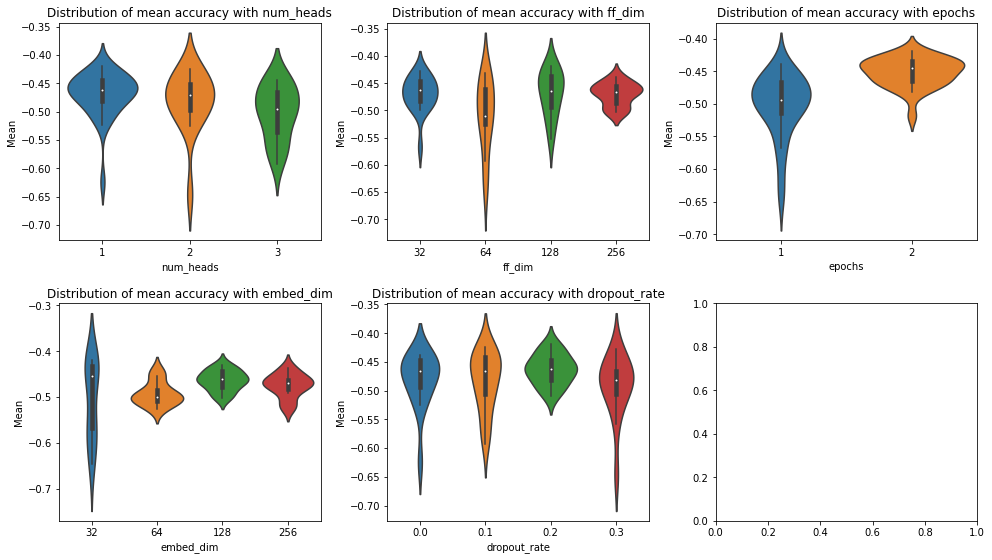

In [53]:
param_ = ["num_heads","ff_dim","epochs","embed_dim","dropout_rate"]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(14,8), squeeze=False)
ax = ax.ravel()
for i in range(5):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(param_[i]))
    sns.violinplot(x=param_[i],y='Mean',data=d,ax=ax[i])
fig.tight_layout(pad=1.5)

In [58]:
d.sort_values(by='Mean',ascending = False)

,num_heads,ff_dim,epochs,embed_dim,dropout_rate,Mean,Std. Dev
42,1,128,2,32,0.2,-0.419242,0.011888
55,2,128,2,32,0.1,-0.424238,0.008373
28,1,32,2,32,0.3,-0.428155,0.006026
0,2,32,2,128,0.2,-0.429107,0.011822
14,1,64,2,32,0.2,-0.431495,0.013794
21,1,64,2,128,0.3,-0.431603,0.007387
11,1,128,2,32,0.1,-0.433905,0.011194
37,2,32,2,256,0.1,-0.436534,0.009000
34,1,256,1,256,0.0,-0.438767,0.005630
38,2,128,2,128,0.1,-0.440442,0.022234


1636840724.673935

1636840728.7788777